# Ridge Model

In this model we will be implementing a Ridge Regression model

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [4]:
# Loading the cleaned data
train = pd.read_csv('../datasets/train_cleaned.csv')
test = pd.read_csv('../datasets/test_cleaned.csv')

In [5]:
# Adding the engineered features
# Age
train['age'] = train['yr_sold'] - train['year_built']
test['age'] = test['yr_sold'] - test['year_built']

# Remodel Age
train['remodel_age'] = train['yr_sold'] - train['year_remod/add']
test['remodel_age'] = test['yr_sold'] - test['year_remod/add']

# Total_bath
train['total_bath'] = (train['full_bath'] + 
                       train['half_bath'] * 0.5 + 
                       train['bsmt_full_bath'] + 
                       train['bsmt_half_bath'] * 0.5)
                       
test['total_bath'] = (test['full_bath'] + 
                      test['half_bath'] * 0.5 + 
                      test['bsmt_full_bath'] + 
                      test['bsmt_half_bath'] * 0.5)

#tot_sqft
train['total_sf'] = train['total_bsmt_sf'] + train['1st_flr_sf'] + train['2nd_flr_sf'] + train['garage_area']
test['total_sf'] = test['total_bsmt_sf'] + test['1st_flr_sf'] + test['2nd_flr_sf'] + test['garage_area']

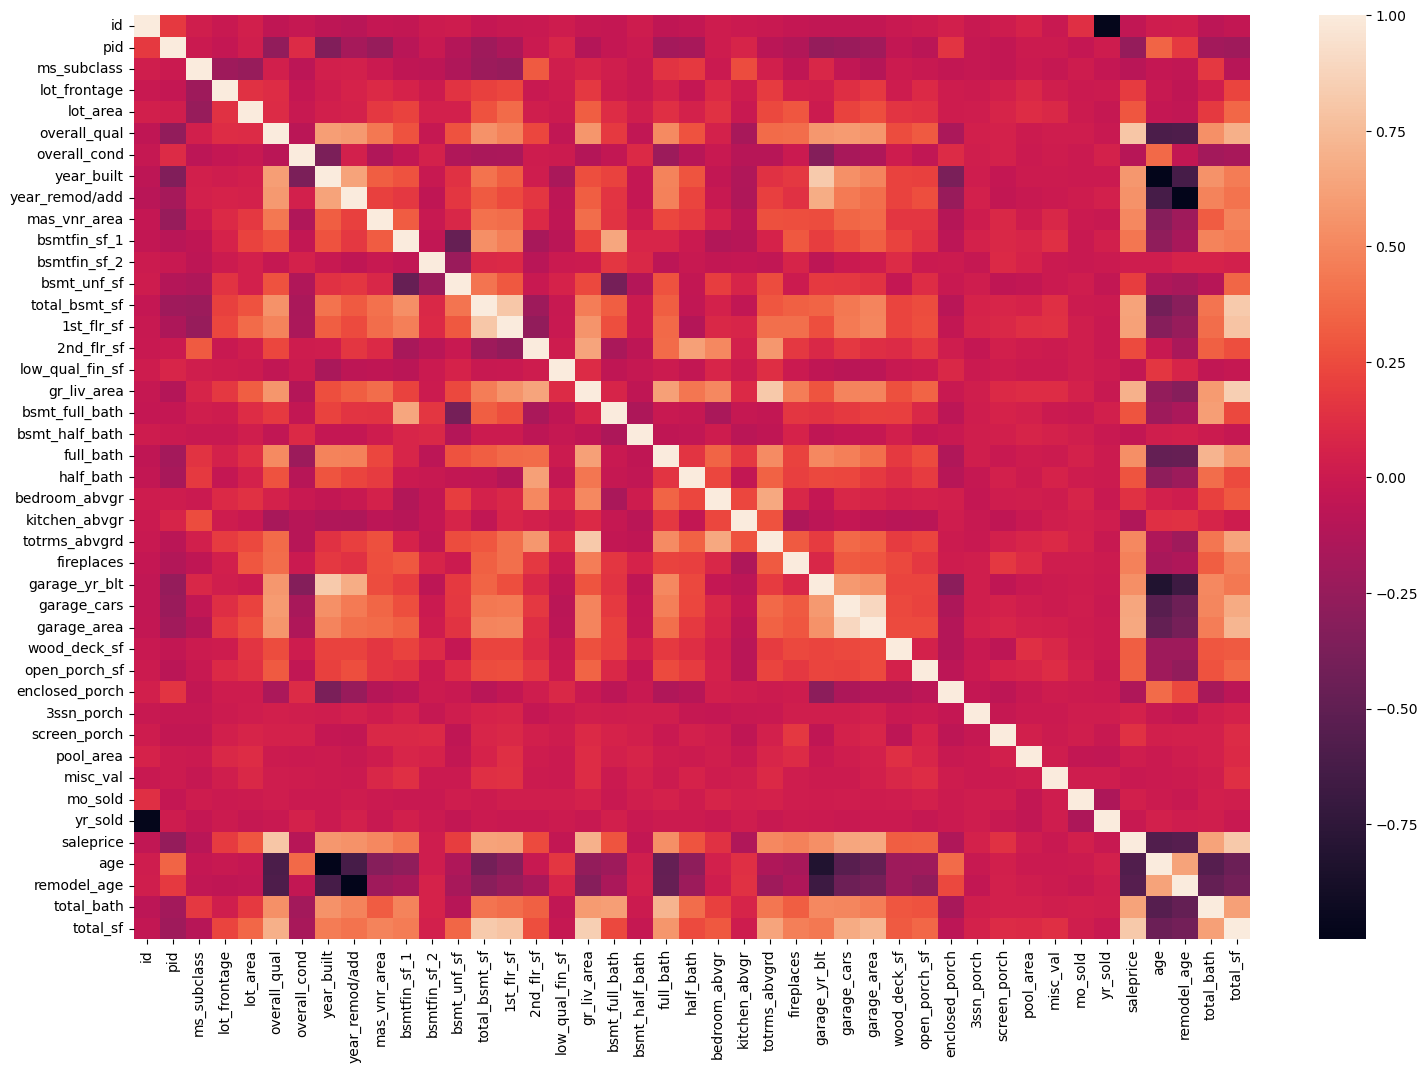

In [6]:
# Making a correlation map of all quantitative variables
corr = train.corr(numeric_only=True)
plt.figure(figsize=(18, 12))
sns.heatmap(corr)
plt.savefig('../images/initial_corr.png')

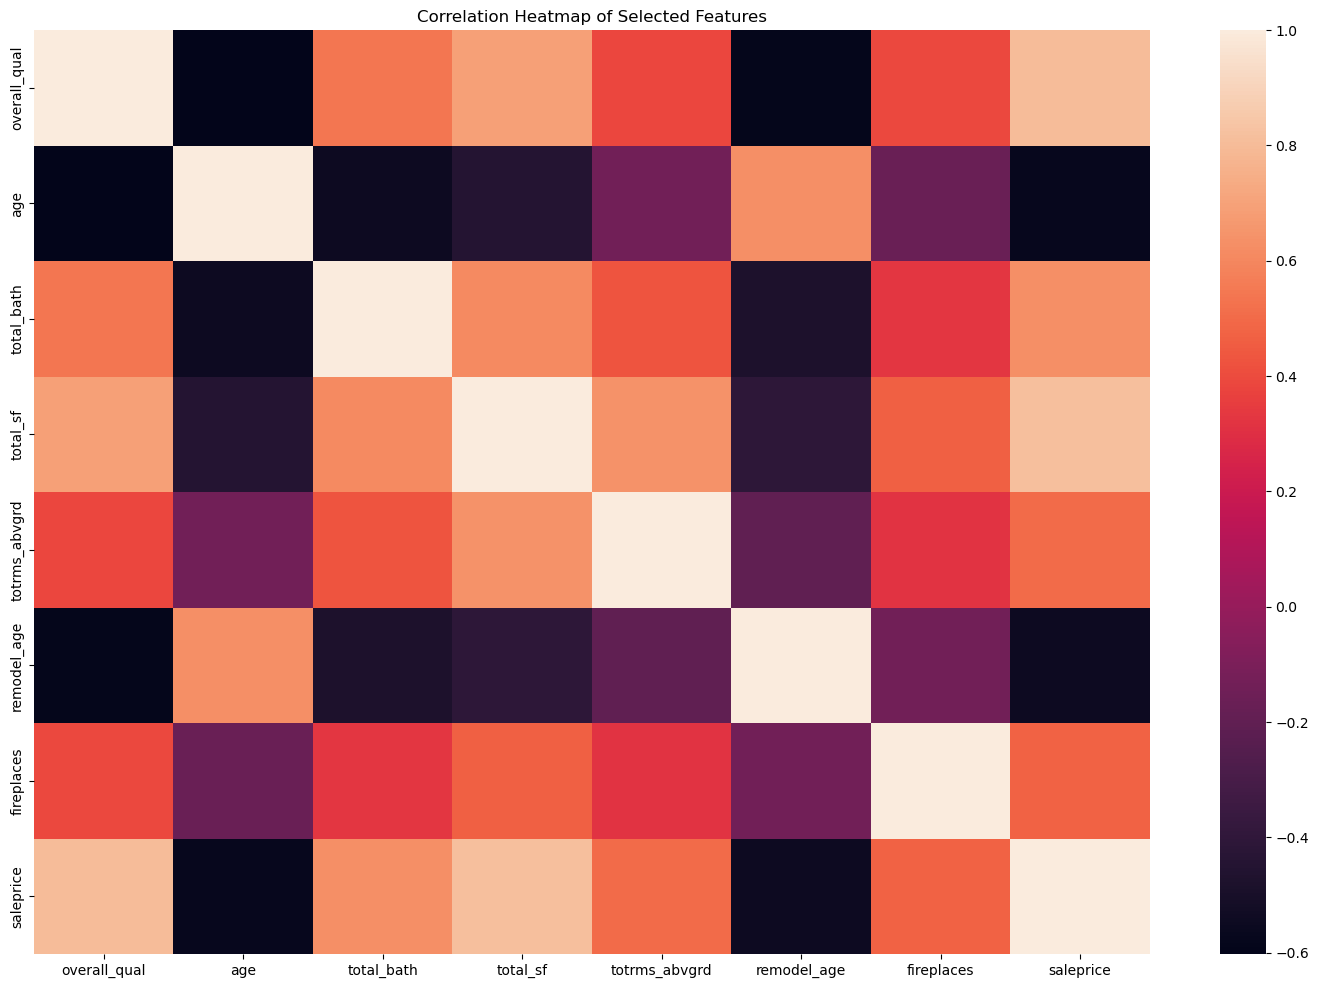

In [7]:
# Computing  the correlation matrix for the selected columns
corr_actual = train[['overall_qual', 'age', 'total_bath', 'total_sf', 'totrms_abvgrd', 'remodel_age', 'fireplaces', 'saleprice']].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr_actual)
plt.title("Correlation Heatmap of Selected Features")

plt.savefig('../images/sel_features_corr.png')

plt.show()

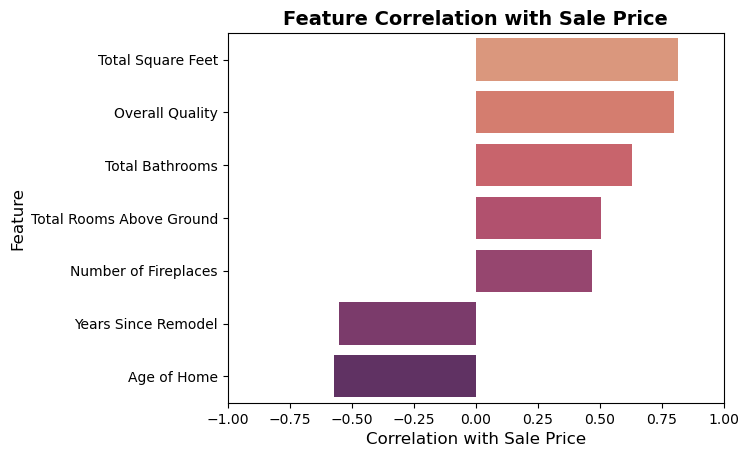

In [8]:

# Computing correlation matrix and sort values
corr_actual = train[['overall_qual', 'age', 'total_bath', 'total_sf', 'totrms_abvgrd', 'remodel_age', 'fireplaces', 'saleprice']].corr()
corr_sorted = corr_actual['saleprice'].drop('saleprice').sort_values(ascending=False)

# Defining a dictionary to rename features
feature_labels = {
    'overall_qual': 'Overall Quality',
    'age': 'Age of Home',
    'total_bath': 'Total Bathrooms',
    'total_sf': 'Total Square Feet',
    'totrms_abvgrd': 'Total Rooms Above Ground',
    'remodel_age': 'Years Since Remodel',
    'fireplaces': 'Number of Fireplaces'
}

# Apply the mapping to rename features
corr_sorted.index = [feature_labels.get(feature, feature) for feature in corr_sorted.index]

colors = sns.color_palette("flare", len(corr_sorted))

sns.barplot(x=corr_sorted.values, y=corr_sorted.index, hue=corr_sorted.index, palette=colors, legend=False)
plt.xlim(-1, 1)

plt.xlabel("Correlation with Sale Price", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Correlation with Sale Price", fontsize=14, weight="bold")

plt.savefig('../images/corr_barchart.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/k9/3tn6m1vs7vv28wc7bsh3y12m0000gn/T/ipykernel_8238/1301953072.py:5: UserWarning: 
The palette list has fewer values (4) than needed (28) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=train.groupby("neighborhood")["saleprice"].mean().index,


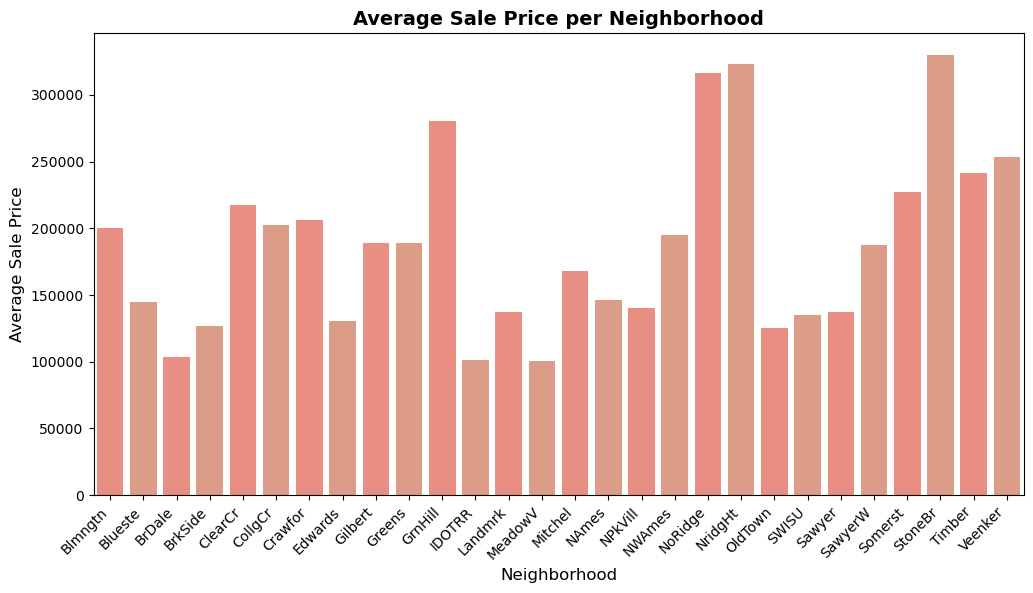

In [9]:
# Creating a barchart of avg saleprice by neighborhood
plt.figure(figsize=(12, 6))
neutral_palette = sns.color_palette(["#FA8072", "#E9967A", "#FA8072", "#E9967A"])

sns.barplot(x=train.groupby("neighborhood")["saleprice"].mean().index, 
            y=train.groupby("neighborhood")["saleprice"].mean().values, 
            hue=train.groupby("neighborhood")["saleprice"].mean().index, 
            palette=neutral_palette,
            legend=False) 

plt.xticks(rotation=45, ha="right")

plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("Average Sale Price", fontsize=12)
plt.title("Average Sale Price per Neighborhood", fontsize=14, weight="bold")
plt.savefig('../images/bar_chart_neighborhood.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# dropping garage_yr_blt since it had many null variables and is not a part of our model
train = train.drop(columns=['garage_yr_blt'])
test = test.drop(columns=['garage_yr_blt'])

In [11]:
#log transforming saleprice
train["saleprice"] = np.log1p(train["saleprice"])

In [12]:
# One-hot encoding
train = pd.get_dummies(train, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

In [13]:
train, test = train.align(test, join="left", axis=1, fill_value=0)

In [14]:
# Now lets apply the last model from Notebook 3
# Train test split
X_train = train[['overall_qual','age', 'total_bath', 'total_sf', 'totrms_abvgrd', 'remodel_age', 'fireplaces'] + [col for col in train.columns if 'neighborhood' in col] + [col for col in train.columns if 'exter_qual' in col] + [col for col in train.columns if 'bsmt_qual' in col] + [col for col in train.columns if 'sale_type' in col] + [col for col in train.columns if 'functional' in col] + [col for col in train.columns if 'exterior_1st' in col] + [col for col in train.columns if 'garage_finish' in col] + [col for col in train.columns if 'kitchen_qual' in col]]
y_train = train['saleprice']

# Ensuring test set has the same features as train
X_test = test.copy()
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)


In [15]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
 # Using pipeline for scaling
ridge = make_pipeline(StandardScaler(), Ridge(alpha=10)) 
ridge.fit(X_train, y_train)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=10))])

In [16]:
ridge_preds = ridge.predict(X_test)

In [17]:
# Converting back to regular units
ridge_preds = np.expm1(ridge_preds)

In [18]:
# fitting to kaggle format
submission = pd.DataFrame({'id': test['id']})
submission['saleprice'] = ridge_preds
submission.head()

,id,saleprice
0,2658,109321.118904
1,2718,182597.980122
2,2414,205396.063244
3,1989,115376.231047
4,625,179243.404461


In [19]:
submission.to_csv('../datasets/ridge_model_1.csv', index=False)